## Stock Price Prediction using LSTM Recurrent Neural Networks

### 1. Import libraries and load datasets
- Import Python libraries
- Load the stock price data of Google, Amazon, Facebook and Apple using the Tiingo API 

In [23]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import pandas_datareader as pdr
from pandas_datareader import data
from datetime import datetime, date
import config
import math

# for MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

# for building LSTM Recurrent Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# for evaluation metrics
from sklearn.metrics import mean_squared_error

In [2]:
## collect the data 
# api_key for the Tiingo API
key = config.api_key

# tech companies whose stock price data is collected
tech_companies = ['Google', 'Amazon', 'Facebook', 'Apple']
companies_ticker = ['GOOGL', 'AMZN', 'FB', 'AAPL']

# set the start date and end date of the data to be collected
end_date = datetime.now()
start_date = datetime(end_date.year - 2, end_date.month, end_date.day)

# collect data using the respective ticker symbols
for ticker in companies_ticker:
    globals()[ticker] = pdr.get_data_tiingo(ticker, start_date, end_date, api_key = key)
    
# convert the files into csv format and create a dataframe
companies_list = [GOOGL, AMZN, FB, AAPL]

for company_data, company_name in list(zip(companies_list, tech_companies)):
    company_data.to_csv(company_name + '.csv')
    
# load the datasets
for company_name in tech_companies:
    globals()[company_name] = pd.read_csv(company_name +'.csv')

### Data Exploration

In [3]:
# the datasets look like,
Google.head(5)

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOGL,2019-05-31 00:00:00+00:00,1106.50,1113.40,1103.35,1105.64,1579481,1106.50,1113.40,1103.35,1105.64,1579481,0.0,1.0
1,GOOGL,2019-06-03 00:00:00+00:00,1038.74,1067.00,1027.03,1066.93,4844480,1038.74,1067.00,1027.03,1066.93,4844480,0.0,1.0
2,GOOGL,2019-06-04 00:00:00+00:00,1054.49,1058.44,1036.03,1044.49,3025564,1054.49,1058.44,1036.03,1044.49,3025564,0.0,1.0
3,GOOGL,2019-06-05 00:00:00+00:00,1044.64,1056.81,1033.00,1055.00,2349436,1044.64,1056.81,1033.00,1055.00,2349436,0.0,1.0
4,GOOGL,2019-06-06 00:00:00+00:00,1047.76,1050.00,1035.51,1046.21,1451026,1047.76,1050.00,1035.51,1046.21,1451026,0.0,1.0


In [84]:
Google.shape

(504, 14)

In [85]:
Google.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       504 non-null    object 
 1   date         504 non-null    object 
 2   close        504 non-null    float64
 3   high         504 non-null    float64
 4   low          504 non-null    float64
 5   open         504 non-null    float64
 6   volume       504 non-null    int64  
 7   adjClose     504 non-null    float64
 8   adjHigh      504 non-null    float64
 9   adjLow       504 non-null    float64
 10  adjOpen      504 non-null    float64
 11  adjVolume    504 non-null    int64  
 12  divCash      504 non-null    float64
 13  splitFactor  504 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 55.2+ KB


- In this project we are building a model to predict the adjusted close price of the companies.
- The companies we will be analyzing in this project are the Big Four Tech Companies Google, Amazon, Facebook and Apple.
- The dataset consists of 2 years of stock price data i.e., from May 31st 2019 to May 28th 2021.

In [19]:
# create a dataframe with the adjusted close price of all the companies
company_dict = {'date': Google['date'], 'google':Google['adjClose'], 'amazon':Amazon['adjClose'], 'facebook':Facebook['adjClose'], 'apple':Apple['adjClose']}
df = pd.DataFrame(company_dict)
df.head()

,date,google,amazon,facebook,apple
0,2019-05-31 00:00:00+00:00,1106.50,1775.07,177.47,42.961548
1,2019-06-03 00:00:00+00:00,1038.74,1692.69,164.15,42.527197
2,2019-06-04 00:00:00+00:00,1054.49,1729.56,167.50,44.083010
3,2019-06-05 00:00:00+00:00,1044.64,1738.50,168.17,44.794659
4,2019-06-06 00:00:00+00:00,1047.76,1754.36,168.33,45.452322


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   date      504 non-null    datetime64[ns, UTC]
 1   google    504 non-null    float64            
 2   amazon    504 non-null    float64            
 3   facebook  504 non-null    float64            
 4   apple     504 non-null    float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 19.8 KB


In [27]:
# transforming the data type of date to datetime
df['date'] = pd.to_datetime(df['date'])

In [33]:
# checking for missing values
df.isnull().sum()

date        0
google      0
amazon      0
facebook    0
apple       0
dtype: int64

In [34]:
# descriptive statistics
df.describe()

,google,amazon,facebook,apple
count,504.000000,504.000000,504.000000,504.000000
mean,1527.039365,2535.262063,232.022768,90.129856
std,348.225624,642.616158,44.776565,30.292449
min,1038.740000,1676.610000,146.010000,42.527197
25%,1251.085000,1864.465000,191.625000,63.415643
50%,1447.255000,2471.725000,227.825000,80.403433
75%,1740.542500,3169.202500,269.105000,120.643638
max,2392.760000,3531.450000,332.750000,142.704617


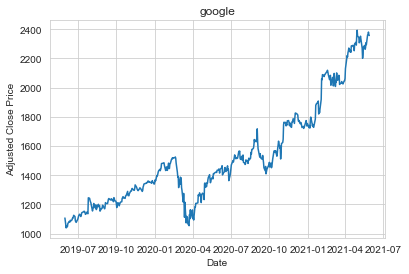

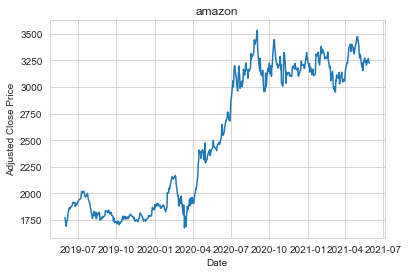

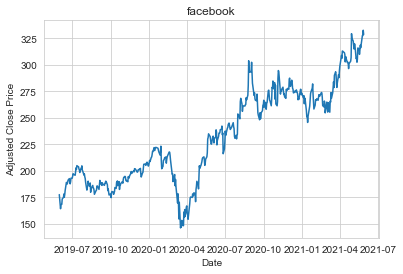

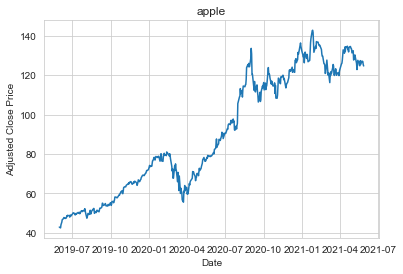

In [81]:
# line plot showing the Adjusted Closing price for all the companies
for column in df.drop('date', axis=1).columns:
    fig, ax = plt.subplots()
    ax.plot('date', column, data=df)
    plt.title('{}'.format(column))
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')

- we can observe a sharp dip at the end of first quarter of 2020 in all the companies, this behavior can attributed to the increase in the number of covid-19 cases which consequently led to the lockdown of cities and countries during that time. 

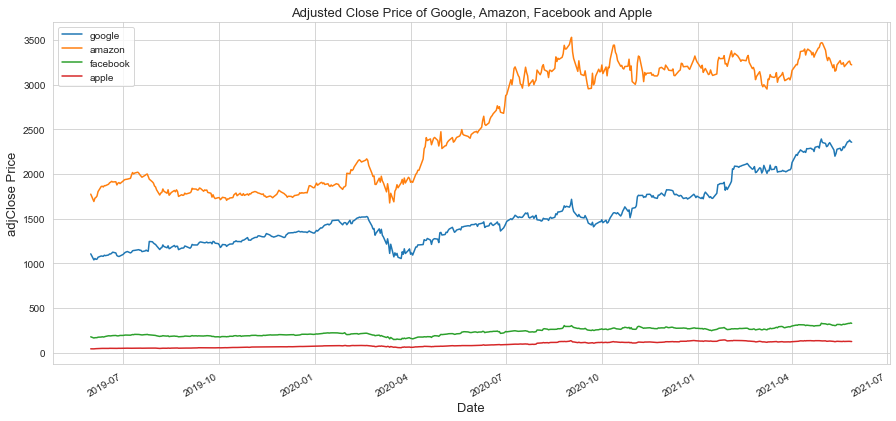

In [56]:
# comparision of the adjusted closing price of all the companies
df.plot(x = 'date', y = ['google', 'amazon', 'facebook', 'apple'], kind='line', figsize=(15,7))
plt.xlabel('Date', fontsize=13)
plt.ylabel('adjClose Price', fontsize=13)
plt.title('Adjusted Close Price of Google, Amazon, Facebook and Apple', fontsize=13)
plt.show()

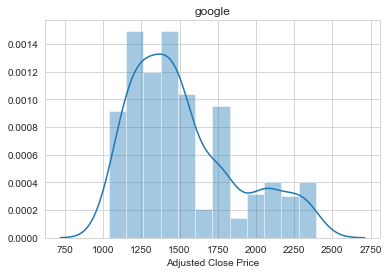

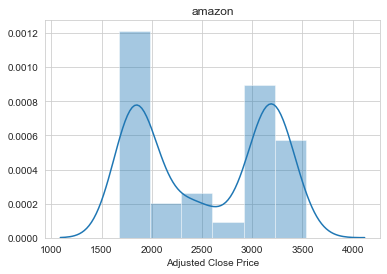

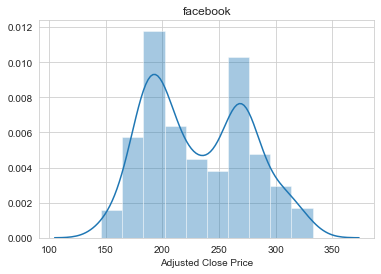

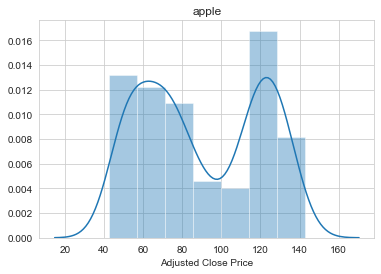

In [83]:
# dist plot showing the distribution of Adjusted Closing price for all the companies
for column in df.drop('date', axis=1).columns:
    fig, ax = plt.subplots()
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    plt.xlabel('Adjusted Close Price')

- We can observe bimodel distribution in the plots of Amazon, Facebook and apple

### 2. Data Preprocessing
- We'll scale the data to get all the values between 0 and 1 using MinMax Scaler.
- we'll create a document matrix with X features and a Y lable. The specified timesteps would determine the number of previous data points(which would be the X features) to be considered to predict the next value(which would be the Y label).
- We'll reshape the data to make it compatible to be pushed through the LSTM algorithm.

In [137]:
# create a function to scale the data
def scaling(data):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(np.array(data).reshape(-1,1))
    return scaled_data

In [103]:
# create a function to create the document matrix
def create_document_matrix(scaled_data, timesteps):
    x = []
    y = []
    for i in range(len(scaled_data)-timesteps-1):
        x.append(scaled_data[i:(i+timesteps), 0])
        y.append(scaled_data[i+timesteps, 0])
    
    X = np.array(x)
    Y = np.array(y)
    
    return X, Y

In [104]:
# create a function to reshape the data
def reshape(X):
    reshaped_X = X.reshape(X.shape[0], X.shape[1], 1)
    return reshaped_X

#### Building the LSTM Neural Network
- We'll create a Neural Network with one input layer, two hidden layers and one output layer. We'll use mean squared error as 
the loss function and 'adam' as an optimizer.

In [126]:
# define the keras odel
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (30, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

# compile the keras model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [127]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


### Let's begin building our prediction model for Google

In [114]:
# train test split, 75% of the data is taken as train set and the rest as test set
train_google = df['google'][0:int(len(df['google'])*0.75)]
test_google = df['google'][len(train_google):len(df['google'])]

In [130]:
# preprocessing the train data
# scaling
scaled_train = scaling(train_google)

# creating a documrnt matrix
X_train, y_train = create_document_matrix(scaled_train, 30)

# reshaping the data
X_train = reshape(X_train)
X_train.shape

(347, 30, 1)

In [128]:
# preprocessing the test data
# scaling
scaled_test = scaling(test_google)

# creating a documrnt matrix
X_test, y_test = create_document_matrix(scaled_test, 30)

# reshaping the data
X_test = reshape(X_test)
X_test.shape

(95, 30, 1)

In [131]:
# training the model using the train data
model.fit(X_train, y_train, epochs=100, batch_size=30)

Epoch 1/100
12/12 [==============================] - 1s 65ms/step - loss: 0.0807
Epoch 2/100
12/12 [==============================] - 1s 61ms/step - loss: 0.0172
Epoch 3/100
12/12 [==============================] - 1s 49ms/step - loss: 0.0124
Epoch 4/100
12/12 [==============================] - 1s 73ms/step - loss: 0.0110
Epoch 5/100
12/12 [==============================] - 1s 76ms/step - loss: 0.0097
Epoch 6/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0094
Epoch 7/100
12/12 [==============================] - 1s 48ms/step - loss: 0.0092
Epoch 8/100
12/12 [==============================] - 0s 42ms/step - loss: 0.0086
Epoch 9/100
12/12 [==============================] - 1s 50ms/step - loss: 0.0076
Epoch 10/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0072
Epoch 11/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0064
Epoch 12/100
12/12 [==============================] - 1s 43ms/step - loss: 0.0065
Epoch 13/100
12/12 [=====

In [132]:
# predicting on the test data
test_predict = model.predict(X_test)

In [135]:
# evaluation
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print("The Root mean squared error in predictions is {}".format(rmse))

The Root mean squared error in predictions is 0.06842548021914097


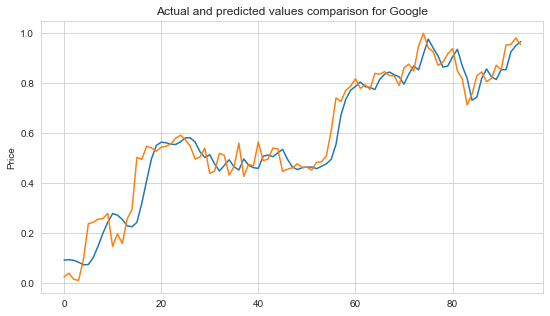

In [144]:
# plot to compare the actual and the predicted values
plt.figure(figsize=(9,5))

plt.plot(test_predict, label='Predicted')
plt.plot(y_test, label='Actual')

plt.title('Actual and predicted values comparison for Google')
plt.ylabel('Price')
plt.show()

### Prediction Model for Amazon

In [146]:
# train test split, 75% of the data is taken as train set and the rest as test set
train_amazon = df['amazon'][0:int(len(df['amazon'])*0.75)]
test_amazon = df['amazon'][len(train_amazon):len(df['amazon'])]

In [147]:
# preprocessing the train data
# scaling
scaled_train = scaling(train_amazon)

# creating a documrnt matrix
X_train, y_train = create_document_matrix(scaled_train, 30)

# reshaping the data
X_train = reshape(X_train)
X_train.shape

(347, 30, 1)

In [148]:
# preprocessing the test data
# scaling
scaled_test = scaling(test_amazon)

# creating a documrnt matrix
X_test, y_test = create_document_matrix(scaled_test, 30)

# reshaping the data
X_test = reshape(X_test)
X_test.shape

(95, 30, 1)

In [149]:
# training the model using the train data
model.fit(X_train, y_train, epochs=100, batch_size=30)

Epoch 1/100
12/12 [==============================] - 1s 47ms/step - loss: 0.0014
Epoch 2/100
12/12 [==============================] - 1s 45ms/step - loss: 0.0013
Epoch 3/100
12/12 [==============================] - 1s 58ms/step - loss: 0.0012
Epoch 4/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0012
Epoch 5/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0012
Epoch 6/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0013
Epoch 7/100
12/12 [==============================] - 1s 43ms/step - loss: 0.0013
Epoch 8/100
12/12 [==============================] - 1s 60ms/step - loss: 0.0012
Epoch 9/100
12/12 [==============================] - 1s 55ms/step - loss: 0.0012
Epoch 10/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0011
Epoch 11/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0011
Epoch 12/100
12/12 [==============================] - 1s 57ms/step - loss: 0.0010
Epoch 13/100
12/12 [=====

In [150]:
# predicting on the test data
test_predict = model.predict(X_test)

# evaluation
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print("The Root mean squared error in predictions is {}".format(rmse))

The Root mean squared error in predictions is 0.10222918899387158


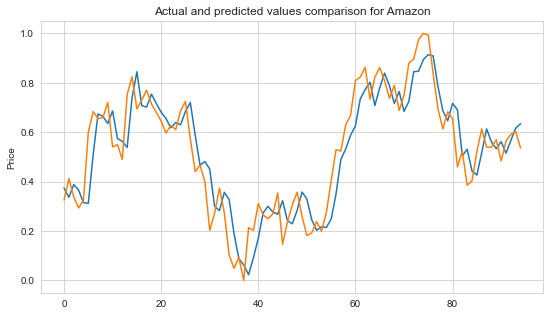

In [152]:
# plot to compare the actual and the predicted values
plt.figure(figsize=(9,5))

plt.plot(test_predict, label='Predicted')
plt.plot(y_test, label='Actual')

plt.title('Actual and predicted values comparison for Amazon')
plt.ylabel('Price')
plt.show()

### Prediction model for Facebook

In [153]:
# train test split, 75% of the data is taken as train set and the rest as test set
train_facebook = df['facebook'][0:int(len(df['facebook'])*0.75)]
test_facebook = df['facebook'][len(train_facebook):len(df['facebook'])]

In [154]:
# preprocessing the train data
# scaling
scaled_train = scaling(train_facebook)

# creating a documrnt matrix
X_train, y_train = create_document_matrix(scaled_train, 30)

# reshaping the data
X_train = reshape(X_train)
X_train.shape

(347, 30, 1)

In [155]:
# preprocessing the test data
# scaling
scaled_test = scaling(test_facebook)

# creating a documrnt matrix
X_test, y_test = create_document_matrix(scaled_test, 30)

# reshaping the data
X_test = reshape(X_test)
X_test.shape

(95, 30, 1)

In [156]:
# training the model using the train data
model.fit(X_train, y_train, epochs=100, batch_size=30)

Epoch 1/100
12/12 [==============================] - 1s 47ms/step - loss: 0.0012
Epoch 2/100
12/12 [==============================] - 1s 54ms/step - loss: 0.0013
Epoch 3/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0012
Epoch 4/100
12/12 [==============================] - 1s 64ms/step - loss: 0.0012: 0s - los
Epoch 5/100
12/12 [==============================] - 1s 56ms/step - loss: 0.0012
Epoch 6/100
12/12 [==============================] - 1s 67ms/step - loss: 0.0012
Epoch 7/100
12/12 [==============================] - 1s 52ms/step - loss: 0.0014
Epoch 8/100
12/12 [==============================] - 1s 48ms/step - loss: 0.0013
Epoch 9/100
12/12 [==============================] - 1s 53ms/step - loss: 0.0012
Epoch 10/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0014
Epoch 11/100
12/12 [==============================] - 1s 62ms/step - loss: 0.0014
Epoch 12/100
12/12 [==============================] - 1s 59ms/step - loss: 0.0012
Epoch 13/100
12

12/12 [==============================] - 1s 55ms/step - loss: 0.0011


In [157]:
# predicting on the test data
test_predict = model.predict(X_test)

# evaluation
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print("The Root mean squared error in predictions is {}".format(rmse))

The Root mean squared error in predictions is 0.06920196610155666


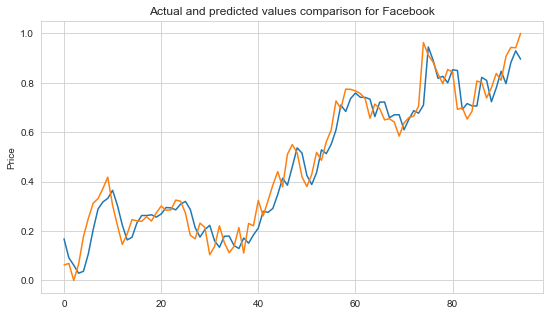

In [158]:
# plot to compare the actual and the predicted values
plt.figure(figsize=(9,5))

plt.plot(test_predict, label='Predicted')
plt.plot(y_test, label='Actual')

plt.title('Actual and predicted values comparison for Facebook')
plt.ylabel('Price')
plt.show()

### Prediction model for Apple

In [159]:
# train test split, 75% of the data is taken as train set and the rest as test set
train_apple = df['apple'][0:int(len(df['apple'])*0.75)]
test_apple = df['apple'][len(train_facebook):len(df['apple'])]

In [160]:
# preprocessing the train data
# scaling
scaled_train = scaling(train_apple)

# creating a documrnt matrix
X_train, y_train = create_document_matrix(scaled_train, 30)

# reshaping the data
X_train = reshape(X_train)
X_train.shape

(347, 30, 1)

In [161]:
# preprocessing the test data
# scaling
scaled_test = scaling(test_apple)

# creating a documrnt matrix
X_test, y_test = create_document_matrix(scaled_test, 30)

# reshaping the data
X_test = reshape(X_test)
X_test.shape

(95, 30, 1)

In [162]:
# training the model using the train data
model.fit(X_train, y_train, epochs=100, batch_size=30)

Epoch 1/100
12/12 [==============================] - 1s 49ms/step - loss: 5.9518e-04
Epoch 2/100
12/12 [==============================] - 1s 44ms/step - loss: 6.0357e-04
Epoch 3/100
12/12 [==============================] - 1s 50ms/step - loss: 5.9797e-04
Epoch 4/100
12/12 [==============================] - 1s 51ms/step - loss: 5.6216e-04
Epoch 5/100
12/12 [==============================] - 1s 60ms/step - loss: 5.4140e-04: 0s - loss:
Epoch 6/100
12/12 [==============================] - 1s 72ms/step - loss: 5.1509e-04
Epoch 7/100
12/12 [==============================] - 1s 47ms/step - loss: 5.6681e-04
Epoch 8/100
12/12 [==============================] - 1s 47ms/step - loss: 5.1534e-04
Epoch 9/100
12/12 [==============================] - 1s 43ms/step - loss: 5.5365e-04
Epoch 10/100
12/12 [==============================] - 1s 48ms/step - loss: 5.0165e-04
Epoch 11/100
12/12 [==============================] - 1s 43ms/step - loss: 6.4265e-04
Epoch 12/100
12/12 [==============================]

In [163]:
# predicting on the test data
test_predict = model.predict(X_test)

# evaluation
rmse = math.sqrt(mean_squared_error(y_test,test_predict))
print("The Root mean squared error in predictions is {}".format(rmse))

The Root mean squared error in predictions is 0.09641931177173155


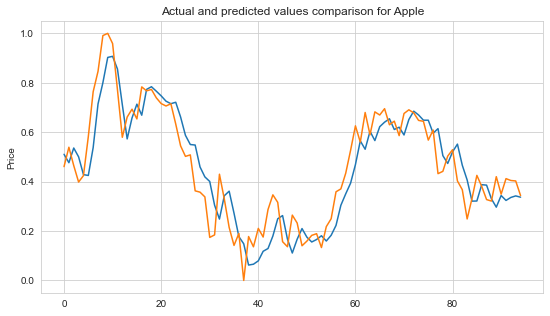

In [164]:
# plot to compare the actual and the predicted values
plt.figure(figsize=(9,5))

plt.plot(test_predict, label='Predicted')
plt.plot(y_test, label='Actual')

plt.title('Actual and predicted values comparison for Apple')
plt.ylabel('Price')
plt.show()

#### Conclusion: 
- With Neural Networks we can build efficient predcition models to forecast the stock prices of publically traded companies and assist traders to make informed decisions to either buy, sell or hold.
- We can further optimize this with the help of Natural Language Processing, with which we can analyze the public tweets or the Reddit threads to understand the market behavior and opinion.